In [1]:
%%capture
%load_ext autoreload
%autoreload 2
#Basic Imports
import os,sys
os.chdir("..")

from tqdm import tqdm,trange
import numpy as np
from sklearn.metrics import classification_report
import torch

from datasets.ssl_dataset import SSL_Dataset
from datasets.data_utils import get_data_loader
from utils import get_model_checkpoints
from utils import net_builder
from utils import clean_results_df
from utils import get_model_checkpoints

import pandas as pd
from termcolor import colored
from copy import deepcopy

## 1) - Set noise parameters

In [2]:
P_noise_dB_min = 0 #[dB], Noise power in dB
P_noise_dB_max = 27 #[dB], Max Noise power in dB 
dP_noise_dB = 3 # [dB], Delta power in dB

## 2) - Initialize parameters

In [3]:
#Path to the runs to load
csv_folder = "/home/gabrielemeoni/project/SSLRS/test"
folder = "/scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/"
sort_criterion = "numlabels" # Accepted net, numlabels
seed_wanted = 0 # Seed wanted (the others will be filtered)

In [4]:
checkpoints, run_args = get_model_checkpoints(folder)
if os.name == 'nt':
       [print(_.split("\\")[1]) for _ in checkpoints];
else:
       [print(_.split("/")[1]) for _ in checkpoints];

scratch
scratch
scratch
scratch
scratch
scratch
scratch
scratch
scratch
scratch


## 3) - Evaluate all test data

In [12]:
results = []
for checkpoint, args in zip(checkpoints,run_args):
    print("------------ RUNNING ", checkpoint, " -----------------")
    print(args)
    args["batch_size"] = 256
    args["data_dir"] = "./data/"
    args["use_train_model"] = False
    args["load_path"] = checkpoint
    
    if args["seed"] == seed_wanted:
        checkpoint_path = os.path.join(args["load_path"])
        checkpoint = torch.load(checkpoint_path,map_location='cuda:0')
        load_model = (checkpoint["train_model"] if args["use_train_model"] else checkpoint["eval_model"])
        _net_builder = net_builder(args["net"],False,{})
        _eval_dset = SSL_Dataset(name=args["dataset"], train=False, data_dir=args["data_dir"], seed=args["seed"])
        eval_dset = _eval_dset.get_dset()
        inv_transf = _eval_dset.inv_transform
        transf = _eval_dset.transform
        net = _net_builder(num_classes=_eval_dset.num_classes, in_channels=_eval_dset.num_channels)
        net.load_state_dict(load_model)
        if torch.cuda.is_available():
            net.cuda()
        net.eval()
                        
        eval_loader = get_data_loader(eval_dset, args["batch"], num_workers=1)
        label_encoding = _eval_dset.label_encoding
        dB_value_list = []
        resuts_run = []
        
        for P_noise_dB in range(P_noise_dB_min, P_noise_dB_max, dP_noise_dB):
            print("------------ PREDICTING TESTSET ----------------- - Noise value [dB]", P_noise_dB)
            
            
            images, labels, preds = [],[],[]
            with torch.no_grad():
                for image, target in tqdm(eval_loader):
                    image_preprocessed=[]
                    for idx,img in enumerate(image):
                        img=255 * inv_transf(img.transpose(0,2).cpu().numpy())
                        img_orig=img
                        for n in range(img.shape[0]):
                            img[n]=(0.5 + 0.75 * torch.rand(size=(1,))) * img[n]
                        
                        A_noise = (10**(P_noise_dB/20))
                        noise=torch.randn(size=img.shape) * A_noise
                        img+= noise
                        
                        image[idx] = transf(1/255*torch.clip(img, 0, 255).transpose(0,2).cpu().numpy())
                            
                    logit = net(image.cuda())
                    preds.append(logit.cpu().max(1)[1])
                    labels.append(target)
            labels = torch.cat(labels).numpy()
            preds = torch.cat(preds).numpy()
            test_report = classification_report(labels, preds, target_names=label_encoding, output_dict=True)
            test_report["params"] = args
            dB_value_list.append("P_noise_"+str(P_noise_dB)+"_dB")
            resuts_run.append(test_report)
        results_noise_dict = dict(zip(dB_value_list, resuts_run))
        results.append(results_noise_dict)

  0%|          | 0/10 [00:00<?, ?it/s]

------------ RUNNING  /scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed0_numlabels500_optSGD/model_best.pth  -----------------
{'dataset': 'eurosat_rgb', 'net': 'efficientnet-b2', 'batch': 32, 'confidence': 0.95, 'lr': 0.03, 'uratio': 7, 'wd': 0.00075, 'wu': 1.0, 'seed': 0, 'numlabels': 500, 'opt': 'SGD', 'iterations': 461000, 'batch_size': 256, 'data_dir': './data/', 'use_train_model': False, 'load_path': '/scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed0_numlabels500_optSGD/model_best.pth'}
Using not pretrained model efficientnet-b2 ...


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 0


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 3


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 6


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 9


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 12


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 15


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 18


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 21


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 24


  0%|          | 0/10 [00:00<?, ?it/s]

------------ RUNNING  /scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed0_numlabels3000_optSGD/model_best.pth  -----------------
{'dataset': 'eurosat_rgb', 'net': 'efficientnet-b2', 'batch': 32, 'confidence': 0.95, 'lr': 0.03, 'uratio': 7, 'wd': 0.00075, 'wu': 1.0, 'seed': 0, 'numlabels': 3000, 'opt': 'SGD', 'iterations': 495000, 'batch_size': 256, 'data_dir': './data/', 'use_train_model': False, 'load_path': '/scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed0_numlabels3000_optSGD/model_best.pth'}
Using not pretrained model efficientnet-b2 ...


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 0


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 3


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 6


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 9


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 12


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 15


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 18


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 21


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 24


  0%|          | 0/10 [00:00<?, ?it/s]

------------ RUNNING  /scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed0_numlabels100_optSGD/model_best.pth  -----------------
{'dataset': 'eurosat_rgb', 'net': 'efficientnet-b2', 'batch': 32, 'confidence': 0.95, 'lr': 0.03, 'uratio': 7, 'wd': 0.00075, 'wu': 1.0, 'seed': 0, 'numlabels': 100, 'opt': 'SGD', 'iterations': 493000, 'batch_size': 256, 'data_dir': './data/', 'use_train_model': False, 'load_path': '/scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed0_numlabels100_optSGD/model_best.pth'}
Using not pretrained model efficientnet-b2 ...


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 0


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 3


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 6


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 9


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 12


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 15


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 18


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 21


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 24


  0%|          | 0/10 [00:00<?, ?it/s]

------------ RUNNING  /scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed3_numlabels100_optSGD/model_best.pth  -----------------
{'dataset': 'eurosat_rgb', 'net': 'efficientnet-b2', 'batch': 32, 'confidence': 0.95, 'lr': 0.03, 'uratio': 7, 'wd': 0.00075, 'wu': 1.0, 'seed': 3, 'numlabels': 100, 'opt': 'SGD', 'iterations': 0, 'batch_size': 256, 'data_dir': './data/', 'use_train_model': False, 'load_path': '/scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed3_numlabels100_optSGD/model_best.pth'}
------------ RUNNING  /scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed3_numlabels500_optSGD/model_best.pth  -----------------
{'dataset': 'eurosat_rgb', 'net': 'efficientnet-b2', 'batch': 32, 'confidence': 0.95,

  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 0


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 3


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 6


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 9


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 12


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 15


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 18


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 21


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 24


  0%|          | 0/10 [00:00<?, ?it/s]

------------ RUNNING  /scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed4_numlabels100_optSGD/model_best.pth  -----------------
{'dataset': 'eurosat_rgb', 'net': 'efficientnet-b2', 'batch': 32, 'confidence': 0.95, 'lr': 0.03, 'uratio': 7, 'wd': 0.00075, 'wu': 1.0, 'seed': 4, 'numlabels': 100, 'opt': 'SGD', 'iterations': 0, 'batch_size': 256, 'data_dir': './data/', 'use_train_model': False, 'load_path': '/scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed4_numlabels100_optSGD/model_best.pth'}
------------ RUNNING  /scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed0_numlabels1000_optSGD/model_best.pth  -----------------
{'dataset': 'eurosat_rgb', 'net': 'efficientnet-b2', 'batch': 32, 'confidence': 0.95

  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 0


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 3


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 6


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 9


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 12


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 15


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 18


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 21


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 24


  0%|          | 0/10 [00:00<?, ?it/s]

------------ RUNNING  /scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed0_numlabels50_optSGD/model_best.pth  -----------------
{'dataset': 'eurosat_rgb', 'net': 'efficientnet-b2', 'batch': 32, 'confidence': 0.95, 'lr': 0.03, 'uratio': 7, 'wd': 0.00075, 'wu': 1.0, 'seed': 0, 'numlabels': 50, 'opt': 'SGD', 'iterations': 450000, 'batch_size': 256, 'data_dir': './data/', 'use_train_model': False, 'load_path': '/scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b2_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed0_numlabels50_optSGD/model_best.pth'}
Using not pretrained model efficientnet-b2 ...


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 0


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 3


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 6


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 9


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 12


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 15


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 18


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 21


  0%|          | 0/85 [00:00<?, ?it/s]

------------ PREDICTING TESTSET ----------------- - Noise value [dB] 24


100%|██████████| 85/85 [00:05<00:00, 15.96it/s]

------------ RUNNING  /scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b0_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed4_numlabels100_optSGD/model_best.pth  -----------------
{'dataset': 'eurosat_rgb', 'net': 'efficientnet-b0', 'batch': 32, 'confidence': 0.95, 'lr': 0.03, 'uratio': 7, 'wd': 0.00075, 'wu': 1.0, 'seed': 4, 'numlabels': 100, 'opt': 'SGD', 'iterations': 0, 'batch_size': 256, 'data_dir': './data/', 'use_train_model': False, 'load_path': '/scratch/fixmatch_results/new_runs/nr_of_labels/eurosat_rgb/FixMatch_archefficientnet-b0_batch32_confidence0.95_lr0.03_uratio7_wd0.00075_wu1.0_seed4_numlabels100_optSGD/model_best.pth'}


## 4) - Creating a PANDAS dataframe and export it to CSV file

In [78]:
big_df = pd.DataFrame()
pd.set_option('display.max_columns', None)
for result in results:
    df = pd.DataFrame()
    for dB_value in dB_value_list:
        if dB_value == 'P_noise_0_dB':
            result_0_dB = result['P_noise_0_dB']
            params = result_0_dB["params"]
            df_local = pd.DataFrame(result_0_dB)
            df_local.drop(list(params.keys()),inplace=True)
            accuracy_0_dB = df_local['accuracy']
            df_local.drop(["support","recall","precision"],inplace=True)
            df_local.drop('accuracy',axis=1 ,inplace=True)
            
            for key,val in params.items():
                df_local[key] = val
                
            df_local = df_local.set_index("dataset")
            df_local.insert(len(df_local.columns), 'accuracy - [0dB]', accuracy_0_dB)
            #df_local = df_local.rename(columns={'accuracy': 'accuracy - [0dB]'})
            
            df=df_local
        else:
            results_n_dB = result[dB_value]
            df.insert(len(df.columns), 'accuracy - ['+dB_value.replace("P_noise_","").replace("_dB","")+"dB]", results_n_dB["accuracy"])

    big_df = big_df.append(df)


small_df = clean_results_df(big_df, folder,sort_criterion)
print(small_df)
small_df.to_csv(csv_folder + "_test_results.csv")

             batch pretrained supervised  confidence    lr  uratio       wd  \
dataset                                                                       
eurosat_rgb     32      False      False        0.95  0.03       7  0.00075   
eurosat_rgb     32      False      False        0.95  0.03       7  0.00075   
eurosat_rgb     32      False      False        0.95  0.03       7  0.00075   
eurosat_rgb     32      False      False        0.95  0.03       7  0.00075   
eurosat_rgb     32      False      False        0.95  0.03       7  0.00075   
eurosat_rgb     32      False      False        0.95  0.03       7  0.00075   

              wu  numlabels  opt  iterations  \
dataset                                        
eurosat_rgb  1.0         50  SGD      450000   
eurosat_rgb  1.0        100  SGD      493000   
eurosat_rgb  1.0        500  SGD      461000   
eurosat_rgb  1.0       1000  SGD      478000   
eurosat_rgb  1.0       2000  SGD      494000   
eurosat_rgb  1.0       3000  SG

## 5) - Creating plots

Text(0, 0.5, 'Accuracy [%]')

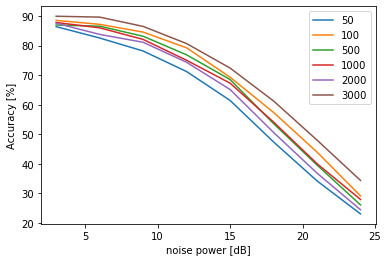

In [83]:
import matplotlib.pyplot as plt

for numlabels in small_df["numlabels"]:
    acc_numlabels=small_df.loc[small_df["numlabels"] == numlabels]
    accuracy_values = []
    for dB_value in dB_value_list:
        accuracy_values.append(acc_numlabels['accuracy - ['+dB_value.replace("P_noise_","").replace("_dB","")+"dB]"] * 100)
    
    plt.plot(np.arange(P_noise_dB_min, P_noise_dB_max, dP_noise_dB), accuracy_values)
    

plt.legend(small_df["numlabels"])
plt.xlabel('noise power [dB]')
plt.ylabel('Accuracy [%]')
    
    
    

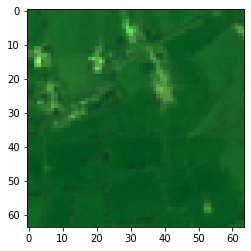

In [9]:
import matplotlib.pyplot as plt
image_plt=img.transpose(0,2).cpu().numpy()
image_plt=(image_plt-image_plt.min()) / (image_plt.max() -image_plt.min())
plt.imshow(image_plt-image_plt.min() / (image_plt.max() -image_plt.min()) * 255)

In [10]:
big_df

,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake,accuracy - [0dB],macro avg,weighted avg,params,net,batch,confidence,lr,uratio,wd,wu,seed,numlabels,opt,iterations,batch_size,data_dir,use_train_model,load_path,accuracy - [3dB],accuracy - [6dB],accuracy - [9dB],accuracy - [12dB],accuracy - [15dB],accuracy - [18dB],accuracy - [21dB],accuracy - [24dB]
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
eurosat_rgb,0.942149,0.888169,0.836120,0.932000,0.843318,0.873508,0.773810,0.924590,0.954092,0.967320,0.896296,0.893508,0.895560,NaN,efficientnet-b2,32,0.95,0.03,7,0.00075,1.0,0,500,SGD,461000,256,./data/,False,/scratch/fixmatch_results/new_runs/nr_of_label...,0.894444,0.885556,0.899259,0.892593,0.893704,0.893704,0.898889,0.895185
eurosat_rgb,0.951261,0.948760,0.827481,0.946721,0.902386,0.900000,0.855967,0.917090,0.949698,0.980066,0.918148,0.917943,0.918922,NaN,efficientnet-b2,32,0.95,0.03,7,0.00075,1.0,0,3000,SGD,495000,256,./data/,False,/scratch/fixmatch_results/new_runs/nr_of_label...,0.918519,0.920000,0.913333,0.911481,0.919630,0.920000,0.920741,0.914444
eurosat_rgb,0.935537,0.933977,0.805324,0.957230,0.904762,0.870647,0.773438,0.951140,0.959184,0.983389,0.909259,0.907463,0.909479,NaN,efficientnet-b2,32,0.95,0.03,7,0.00075,1.0,0,100,SGD,493000,256,./data/,False,/scratch/fixmatch_results/new_runs/nr_of_label...,0.898889,0.907778,0.912963,0.910370,0.907037,0.908889,0.913333,0.907778
eurosat_rgb,0.931596,0.831563,0.814286,0.930612,0.904762,0.878641,0.815900,0.921273,0.947791,0.936508,0.891481,0.891293,0.891134,NaN,efficientnet-b2,32,0.95,0.03,7,0.00075,1.0,0,2000,SGD,494000,256,./data/,False,/scratch/fixmatch_results/new_runs/nr_of_label...,0.889259,0.883333,0.890000,0.885926,0.885185,0.883704,0.889630,0.893333
eurosat_rgb,0.930757,0.905085,0.823161,0.941176,0.893246,0.878860,0.782961,0.919861,0.955645,0.967427,0.900741,0.899818,0.901080,NaN,efficientnet-b2,32,0.95,0.03,7,0.00075,1.0,0,1000,SGD,478000,256,./data/,False,/scratch/fixmatch_results/new_runs/nr_of_label...,0.909259,0.907407,0.900000,0.904815,0.904815,0.910370,0.895926,0.897037
eurosat_rgb,0.920635,0.861154,0.807249,0.940695,0.882096,0.869779,0.746067,0.905473,0.930693,0.949593,0.883704,0.881343,0.882250,NaN,efficientnet-b2,32,0.95,0.03,7,0.00075,1.0,0,50,SGD,450000,256,./data/,False,/scratch/fixmatch_results/new_runs/nr_of_label...,0.888889,0.884074,0.881481,0.890741,0.884815,0.892593,0.892963,0.895185


In [11]:
big_df

,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake,accuracy - [0dB],macro avg,weighted avg,params,net,batch,confidence,lr,uratio,wd,wu,seed,numlabels,opt,iterations,batch_size,data_dir,use_train_model,load_path,accuracy - [3dB],accuracy - [6dB],accuracy - [9dB],accuracy - [12dB],accuracy - [15dB],accuracy - [18dB],accuracy - [21dB],accuracy - [24dB]
dataset,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
eurosat_rgb,0.942149,0.888169,0.836120,0.932000,0.843318,0.873508,0.773810,0.924590,0.954092,0.967320,0.896296,0.893508,0.895560,NaN,efficientnet-b2,32,0.95,0.03,7,0.00075,1.0,0,500,SGD,461000,256,./data/,False,/scratch/fixmatch_results/new_runs/nr_of_label...,0.894444,0.885556,0.899259,0.892593,0.893704,0.893704,0.898889,0.895185
eurosat_rgb,0.951261,0.948760,0.827481,0.946721,0.902386,0.900000,0.855967,0.917090,0.949698,0.980066,0.918148,0.917943,0.918922,NaN,efficientnet-b2,32,0.95,0.03,7,0.00075,1.0,0,3000,SGD,495000,256,./data/,False,/scratch/fixmatch_results/new_runs/nr_of_label...,0.918519,0.920000,0.913333,0.911481,0.919630,0.920000,0.920741,0.914444
eurosat_rgb,0.935537,0.933977,0.805324,0.957230,0.904762,0.870647,0.773438,0.951140,0.959184,0.983389,0.909259,0.907463,0.909479,NaN,efficientnet-b2,32,0.95,0.03,7,0.00075,1.0,0,100,SGD,493000,256,./data/,False,/scratch/fixmatch_results/new_runs/nr_of_label...,0.898889,0.907778,0.912963,0.910370,0.907037,0.908889,0.913333,0.907778
eurosat_rgb,0.931596,0.831563,0.814286,0.930612,0.904762,0.878641,0.815900,0.921273,0.947791,0.936508,0.891481,0.891293,0.891134,NaN,efficientnet-b2,32,0.95,0.03,7,0.00075,1.0,0,2000,SGD,494000,256,./data/,False,/scratch/fixmatch_results/new_runs/nr_of_label...,0.889259,0.883333,0.890000,0.885926,0.885185,0.883704,0.889630,0.893333
eurosat_rgb,0.930757,0.905085,0.823161,0.941176,0.893246,0.878860,0.782961,0.919861,0.955645,0.967427,0.900741,0.899818,0.901080,NaN,efficientnet-b2,32,0.95,0.03,7,0.00075,1.0,0,1000,SGD,478000,256,./data/,False,/scratch/fixmatch_results/new_runs/nr_of_label...,0.909259,0.907407,0.900000,0.904815,0.904815,0.910370,0.895926,0.897037
eurosat_rgb,0.920635,0.861154,0.807249,0.940695,0.882096,0.869779,0.746067,0.905473,0.930693,0.949593,0.883704,0.881343,0.882250,NaN,efficientnet-b2,32,0.95,0.03,7,0.00075,1.0,0,50,SGD,450000,256,./data/,False,/scratch/fixmatch_results/new_runs/nr_of_label...,0.888889,0.884074,0.881481,0.890741,0.884815,0.892593,0.892963,0.895185
